In [3]:
!pip install cairosvg
!pip install opencv-python
!pip install easyocr
!pip install torch torchvision
!pip install transformers
!pip install Pillow
!pip install matplotlib
!pip install scikit-learn
!pip install numpy

🔎 Fetching icons from Eraser docs...


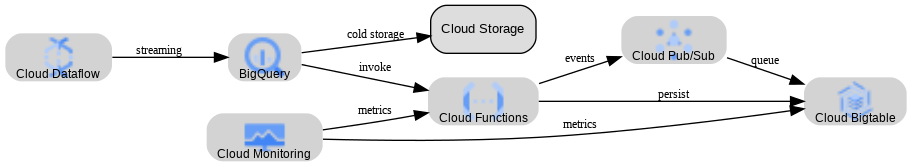

In [9]:
import json
from graphviz import Digraph
from IPython.display import Image, display
import requests
import cairosvg
import os
from bs4 import BeautifulSoup

# ----------------------------
# Step 1: Scrape icon names + URLs from Eraser docs
# ----------------------------
base_url = "https://docs.eraser.io"
icons_url = f"{base_url}/docs/icons"

print("🔎 Fetching icons from Eraser docs...")
res = requests.get(icons_url)
soup = BeautifulSoup(res.text, "html.parser")

icon_dir = "/content/icons"
os.makedirs(icon_dir, exist_ok=True)

# for downloading icons
# Dictionary: { "gcp-bigquery": "/content/icons/gcp-bigquery.png", ... }


icons = {}

for td in soup.find_all("td"):
    img = td.find("img")
    label = td.get_text(strip=True)  # e.g. aws-athena, gcp-bigquery
    if img and label:
        # svg_url = base_url + img["src"]
        from urllib.parse import urljoin

        src = img["src"]
        if src.startswith("//"):
            svg_url = "https:" + src   # protocol-relative → add https:
        else:
            svg_url = urljoin(base_url, src)  # handles relative paths safely

        svg_path = os.path.join(icon_dir, f"{label}.svg")
        png_path = os.path.join(icon_dir, f"{label}.png")

        # Download SVG if not cached
        if not os.path.exists(svg_path):
            r = requests.get(svg_url)
            with open(svg_path, "wb") as f:
                f.write(r.content)

        # Convert SVG -> PNG if not cached
        if not os.path.exists(png_path):
            cairosvg.svg2png(url=svg_path, write_to=png_path)

        icons[label.lower()] = png_path

print(f"✅ Scraped and cached {len(icons)} icons")

# ----------------------------
# Step 2: Load your architecture JSON
# ----------------------------
with open("/content/prompt_0002.json", "r") as f:
    data = json.load(f)

if "messages" in data:
    assistant_content = data["messages"][-1]["content"]
    diagram = json.loads(assistant_content)
else:
    diagram = data

# ----------------------------
# Step 3: Map entities → icons
# ----------------------------
def get_icon(ent):
    service = ent.get("service", "").lower().replace("_", "-")
    cloud = ent.get("cloud_provider", "").lower()
    key = f"{cloud}-{service}"   # e.g. gcp-bigquery
    return icons.get(key)

# ----------------------------
# Step 4: Build Graphviz diagram
# ----------------------------
dot = Digraph("Architecture", format="png")
dot.attr(rankdir="LR", bgcolor="white")
dot.attr("node", shape="rect", style="rounded,filled", fontname="Helvetica", fontsize="10")

# Add nodes
for ent in diagram["entities"]:
    node_id = ent["id"]
    label = ent.get("label", node_id)

    icon_path = get_icon(ent)

    if icon_path:
        dot.node(
            node_id,
            label=label,
            image=icon_path,
            shape="none",
            labelloc="b",
            fontsize="9",
            fixedsize="false",
            imagescale="true"
        )
    else:
        dot.node(
            node_id,
            label=label,
            fillcolor="#DDDDDD",
            color="black"
        )

# Add edges
for rel in diagram["relationships"]:
    style = rel.get("style", {})
    attrs = {}
    if style.get("dash") == "dashed":
        attrs["style"] = "dashed"
    dot.edge(rel["source"], rel["target"], label=rel["label"], fontsize="9")

# Render & display
png_bytes = dot.pipe(format="png")
display(Image(png_bytes))


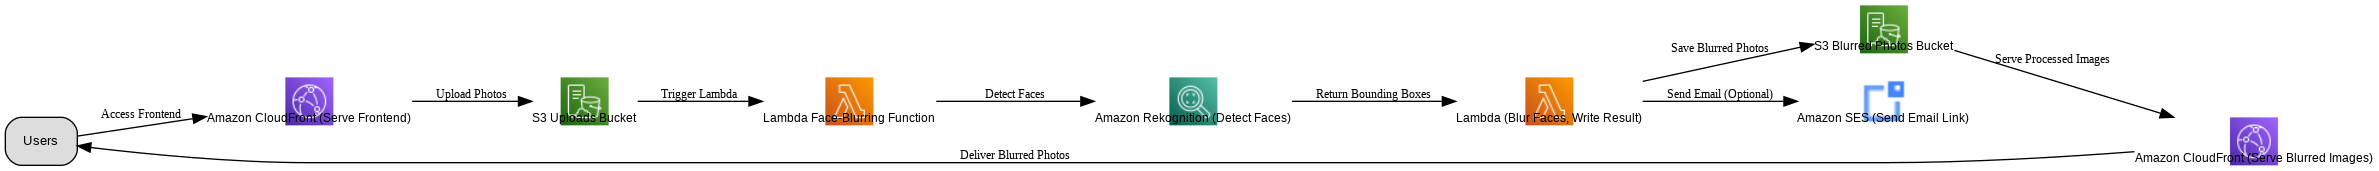

In [22]:
with open("/content/prompt_0002 - Copy.json", "r") as f:
    data = json.load(f)

if "messages" in data:
    assistant_content = data["messages"][-1]["content"]
    diagram = json.loads(assistant_content)
else:
    diagram = data



def get_icon(ent):
    service = ent.get("service", "").lower().replace("_", "-")
    cloud = ent.get("cloud_provider", "").lower()
    key = f"{cloud}-{service}"

    # 🔹 Special-case mapping for users/clients
    if service in ["user", "users", "client", "end-user", "customer"]:
        return icons.get("generic-user")  # <-- put your user/person silhouette key here

    # Exact match first
    if key in icons:
        return icons[key]

    # Fuzzy match within cloud provider
    for k, path in icons.items():
        if cloud in k and service in k:
            return path

    # Fuzzy match fallback (no cloud restriction)
    for k, path in icons.items():
        if service in k:
            return path

    return None


# ----------------------------
# Step 4: Build Graphviz diagram
# ----------------------------
dot = Digraph("Architecture", format="png")
dot.attr(rankdir="LR", bgcolor="white")

# Default node style (only applies to text-only nodes)
dot.attr("node", shape="rect", style="rounded,filled", fontname="Helvetica", fontsize="10", fillcolor="#DDDDDD")

# Add nodes
for ent in diagram["entities"]:
    node_id = ent["id"]
    label = ent.get("label", node_id)
    icon_path = get_icon(ent)

    if icon_path:
        # Icon node with NO box
        dot.node(
            node_id,
            label=label,         # "" if you want icon only
            image=icon_path,
            shape="none",
            labelloc="b",
            fontsize="9",
            fixedsize="false",
            imagescale="true",
            margin="0",
            style=""             # <-- clears the rounded/filled box style
        )
    else:
        # Fallback: normal rectangle node
        dot.node(
            node_id,
            label=label,
            shape="rect",
            style="rounded,filled",
            fillcolor="#DDDDDD",
            color="black"
        )

# Add edges
for rel in diagram["relationships"]:
    style = rel.get("style", {})
    attrs = {}
    if style.get("dash") == "dashed":
        attrs["style"] = "dashed"
    dot.edge(rel["source"], rel["target"], label=rel["label"], fontsize="9")

# Render & display
png_bytes = dot.pipe(format="png")
display(Image(png_bytes))


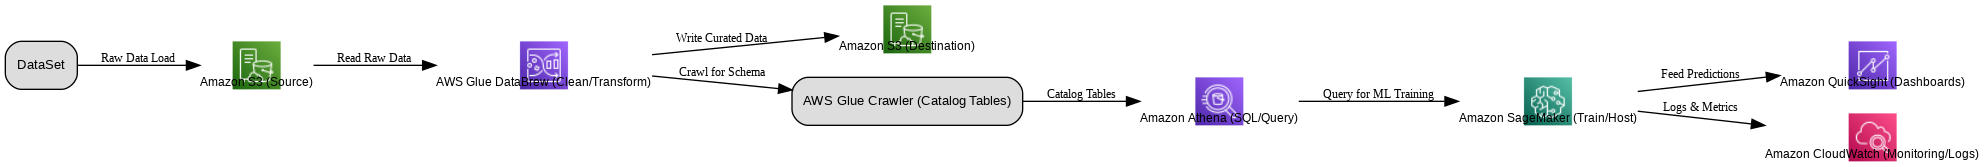

In [24]:
with open("/content/prompt_0002 - Copy.json", "r") as f:
    data = json.load(f)

if "messages" in data:
    assistant_content = data["messages"][-1]["content"]
    diagram = json.loads(assistant_content)
else:
    diagram = data

# ----------------------------
# Step 3: Map entities → icons
# ----------------------------
# def get_icon(ent):
#     service = ent.get("service", "").lower().replace("_", "-")
#     cloud = ent.get("cloud_provider", "").lower()
#     key = f"{cloud}-{service}"   # e.g. gcp-bigquery
#     return icons.get(key)


# def get_icon(ent):
#     service = ent.get("service", "").lower().replace("_", "-")
#     cloud = ent.get("cloud_provider", "").lower()
#     key = f"{cloud}-{service}"   # e.g., aws-s3

#     # Direct exact match first
#     if key in icons:
#         return icons[key]

#     # Fuzzy match: if service name contains part of an icon key
#     for k, path in icons.items():
#         if service in k or k.endswith(service) or service in k.split("-"):
#             if cloud in k:   # make sure cloud matches too
#                 return path

#     # Extra fallback: check just by service name
#     for k, path in icons.items():
#         if service in k:
#             return path

#     return None   # no match found


def get_icon(ent):
    service = ent.get("service", "").lower().replace("_", "-")
    cloud = ent.get("cloud_provider", "").lower()
    key = f"{cloud}-{service}"

    # 🔹 Special-case mapping for users/clients
    if service in ["user", "users", "client", "end-user", "customer"]:
        return icons.get("generic-user")  # <-- put your user/person silhouette key here

    # Exact match first
    if key in icons:
        return icons[key]

    # Fuzzy match within cloud provider
    for k, path in icons.items():
        if cloud in k and service in k:
            return path

    # Fuzzy match fallback (no cloud restriction)
    for k, path in icons.items():
        if service in k:
            return path

    return None


# ----------------------------
# Step 4: Build Graphviz diagram
# ----------------------------
dot = Digraph("Architecture", format="png")
dot.attr(rankdir="LR", bgcolor="white")

# Default node style (only applies to text-only nodes)
dot.attr("node", shape="rect", style="rounded,filled", fontname="Helvetica", fontsize="10", fillcolor="#DDDDDD")

# Add nodes
for ent in diagram["entities"]:
    node_id = ent["id"]
    label = ent.get("label", node_id)
    icon_path = get_icon(ent)

    if icon_path:
        # Icon node with NO box
        dot.node(
            node_id,
            label=label,         # "" if you want icon only
            image=icon_path,
            shape="none",
            labelloc="b",
            fontsize="9",
            fixedsize="false",
            imagescale="true",
            margin="0",
            style=""             # <-- clears the rounded/filled box style
        )
    else:
        # Fallback: normal rectangle node
        dot.node(
            node_id,
            label=label,
            shape="rect",
            style="rounded,filled",
            fillcolor="#DDDDDD",
            color="black"
        )

# Add edges
for rel in diagram["relationships"]:
    style = rel.get("style", {})
    attrs = {}
    if style.get("dash") == "dashed":
        attrs["style"] = "dashed"
    dot.edge(rel["source"], rel["target"], label=rel["label"], fontsize="9")

# Render & display
png_bytes = dot.pipe(format="png")
display(Image(png_bytes))
